In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/style-transfer-dt/style.jpg
/kaggle/input/style-transfer-dt/content-2.png
/kaggle/input/style-transfer-dt/style-2.png
/kaggle/input/style-transfer-dt/content.jpg


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import copy

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Image utilities
fixed_imsize = 512
prep_img = transforms.Compose([
    transforms.Resize((fixed_imsize, fixed_imsize)),
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x[:3, :, :]),  # Take only RGB channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

def img_ldr(path):
    """Load and preprocess image"""
    image = Image.open(path).convert("RGB")
    image = prep_img(image).unsqueeze(0)
    return image.to(device, torch.float)

# Unloader for display
unloader = transforms.Compose([
    transforms.Normalize(mean=[-2.12, -2.04, -1.80],
                         std=[4.37, 4.46, 4.44]),
    transforms.ToPILImage()
])

def imshow(tensor, title=None):
    """Display tensor as image"""
    image = tensor.cpu().clone().squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()


In [5]:
content_image = img_ldr("/kaggle/input/style-transfer-dt/content.jpg")
style_image = img_ldr("/kaggle/input/style-transfer-dt/content-2.png")

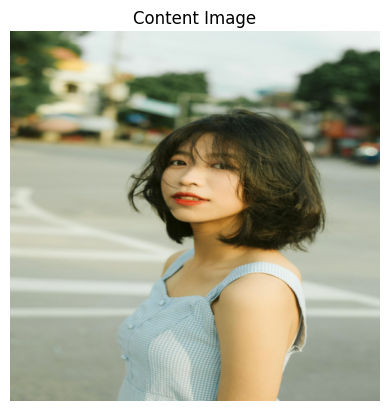

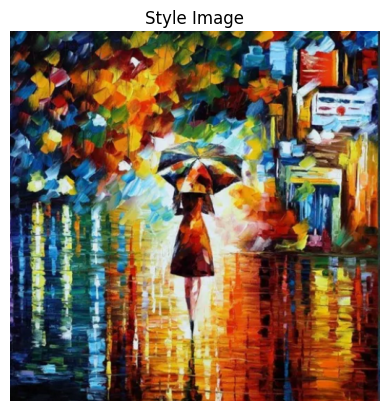

In [6]:
# images being used
imshow(content_image, title='Content Image')
imshow(style_image, title='Style Image')

**Recontruction on of images from each layer of vgg 19**

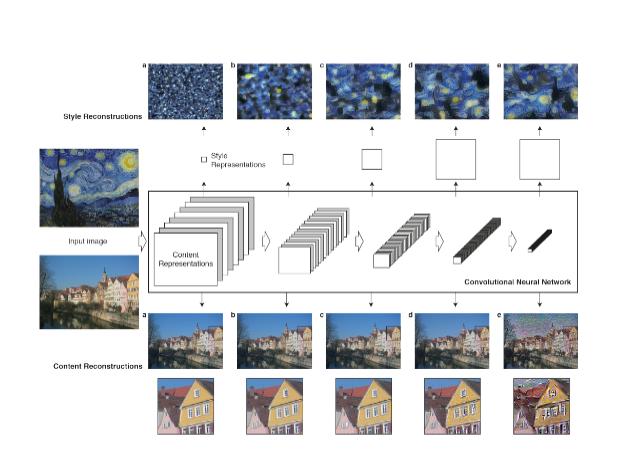

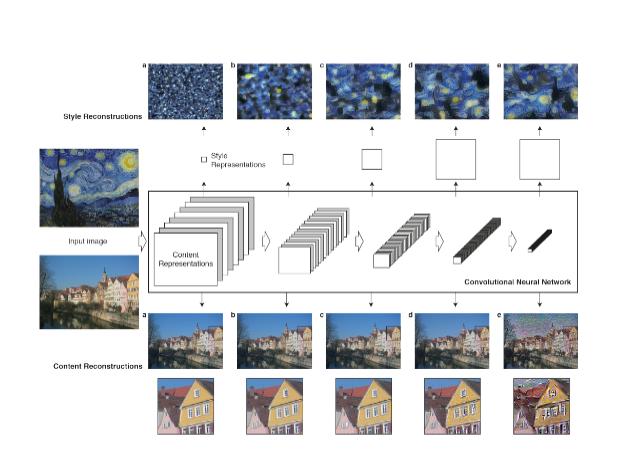

In [7]:
#class for loading the vgg19 model with wanted layers
class VGG(nn.Module):
  def __init__(self):
    super(VGG, self).__init__()
    self.select_features = ['0', '5', '10', '19', '28'] #conv layers
    self.vgg = models.vgg19(pretrained=True).features
  
  def forward(self, output):
    features = []
    for name, layer in self.vgg._modules.items():
      output = layer(output)
      if name in self.select_features:
        features.append(output)
    return features

#load the model
vgg = VGG().to(device).eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 188MB/s]  


In [14]:
# Loss Functions
def gram_matrix(input_tensor):
    _, d, h, w = input_tensor.size()
    
    # Reshape to (batch_size, depth, height*width)
    features = input_tensor.view(d, h * w)
    
    # G = F * F^T
    gram = torch.mm(features, features.t())
    
    gram = gram

    return gram

def content_loss(target_features, content_features):
    loss =  torch.mean((target_features-content_features)**2)
    return loss

def style_loss(target_features, style_features):
    _, c, h, w = target_features.size()
    target_gram = gram_matrix(target_features)
    style_gram = gram_matrix(style_features)
    N = c
    M = h * w
    loss = torch.mean((target_gram-style_gram)**2)/(c*h*w)
    return loss



In [17]:
def run_style_transfer(content_img, style_img, input_img=None, num_steps=300,
                       style_weight=1e6, content_weight=1):
    
    if input_img is None:
        input_img = content_img.clone()
    else:
        input_img = input_img.clone()
    
    input_img = nn.Parameter(input_img.requires_grad_(True))
    
    
    optimizer = torch.optim.Adam([input_img], lr=0.01)
    
    content_features = [feat.detach() for feat in vgg(content_img)]
    style_features = [feat.detach() for feat in vgg(style_img)]
    
     
    
    run = [0]
    while run[0] <= num_steps:
        
        def closure():
            
            input_img.data.clamp_(0, 1)
            
            optimizer.zero_grad()
            
            target_features = vgg(input_img)
        
            
            c_loss = content_loss(target_features[3], content_features[3])

            style_weights = [1,1,1,1,1]
            # Calculate style loss (using all layers)
            s_loss = 0
            for i, (target_feat, style_feat, style_weight) in enumerate(zip(target_features, style_features, style_weights)):
                s_loss += style_loss(target_feat, style_feat) * style_weight

            # Total loss
            total_loss = c_loss * content_weight + s_loss * style_weight
            total_loss.backward()
            
            # Print progress
            if run[0] % 50 == 0:
                print(f"Step {run[0]}:")
                print(f"  Content Loss: {c_loss.item():.4f}")
                print(f"  Style Loss: {s_loss.item():.8f}")
                print(f"  Total Loss: {total_loss.item():.4f}")
                print("-" * 40)
            
            run[0] += 1
            return total_loss
        
        optimizer.step(closure)
        
    
    return input_img



In [18]:
final_img = run_style_transfer(content_image, style_image)

Step 0:
  Content Loss: 4.6328
  Style Loss: 1559.31066895
  Total Loss: 1563.9435
----------------------------------------
Step 50:
  Content Loss: 14.9025
  Style Loss: 533.01477051
  Total Loss: 547.9173
----------------------------------------
Step 100:
  Content Loss: 16.3199
  Style Loss: 321.15072632
  Total Loss: 337.4707
----------------------------------------
Step 150:
  Content Loss: 16.7010
  Style Loss: 249.91224670
  Total Loss: 266.6133
----------------------------------------
Step 200:
  Content Loss: 16.8069
  Style Loss: 217.73390198
  Total Loss: 234.5408
----------------------------------------
Step 250:
  Content Loss: 16.8377
  Style Loss: 200.17916870
  Total Loss: 217.0168
----------------------------------------
Step 300:
  Content Loss: 16.8421
  Style Loss: 189.00489807
  Total Loss: 205.8470
----------------------------------------


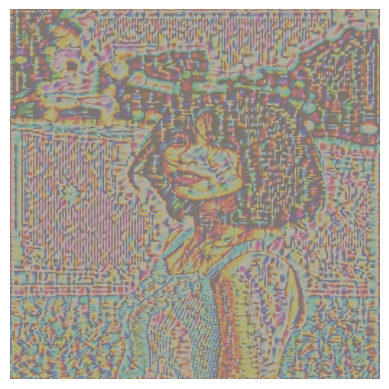

In [19]:
imshow(final_img)